# EV charger scraper

- Notebook to scrape available data on public and private ev chargers in The Netherlands
- Data from [oplaadpalen.nl](https://oplaadpalen.nl/)
- Quick visualization
- part of MSc thesis at Delft University of Technology

@author: Mark Hupkens

In [1]:
import pandas as pd
import requests
# import urllib2
from bs4 import BeautifulSoup
import urllib.request
import numpy as np

### API Parameters

- access_type element of (public, company, private)
- availability (available, in use)
- charging & power (Normal, fast)

### Loop over a range of gps coordinates

In [2]:
# Loop over range to create box
zoom ='15'
accesstype = 'public,company,private' # gather types of chargers
d = {}
boxes = [ (lon, lat) for lon in np.arange(50.5,54,.1) for lat in np.arange (3.4,7.5,.4)]

for count, box in enumerate(boxes):
    if count==0:
        box = (str(boxes[count])+","+str(box))
        box = box.replace(")","").replace("(","").replace(" ","")
    else:
        box = (str(boxes[count-1])+","+str(box))
        box = box.replace(")","").replace("(","").replace(" ","")
    
    url = 'https://oplaadpalen.nl/api/maplist/clusterset?box='+box+'&zoom='+str(zoom)+'&accessType='+accesstype+'&available=available,charging&power=fast,normal'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame.from_dict(data['data'])
    if len(df) != 0: # only save data if len>0
        d[box] = df
        print(box,len(df))


50.5,7.399999999999999,50.6,3.4 58
50.6,7.399999999999999,50.7,3.4 114
50.7,7.399999999999999,50.800000000000004,3.4 297
50.800000000000004,7.399999999999999,50.900000000000006,3.4 603
50.900000000000006,7.399999999999999,51.00000000000001,3.4 537
51.00000000000001,7.399999999999999,51.10000000000001,3.4 479
51.10000000000001,7.399999999999999,51.20000000000001,3.4 491
51.20000000000001,7.399999999999999,51.30000000000001,3.4 487
51.30000000000001,7.399999999999999,51.40000000000001,3.4 362
51.40000000000001,7.399999999999999,51.500000000000014,3.4 843
51.500000000000014,7.399999999999999,51.600000000000016,3.4 932
51.600000000000016,7.399999999999999,51.70000000000002,3.4 664
51.70000000000002,7.399999999999999,51.80000000000002,3.4 548
51.80000000000002,7.399999999999999,51.90000000000002,3.4 1448
51.90000000000002,7.399999999999999,52.00000000000002,3.4 1790
52.00000000000002,7.399999999999999,52.10000000000002,3.4 2616
52.10000000000002,7.399999999999999,52.200000000000024,3.4 1577

In [3]:
# Show length of all stored dataframes
l=[]
for key in d:
    l.append(len(d[key]))
sum(l)

20271

In [4]:
# Save unique heading combinations
l2=[]
for key in d:
    if d[key].columns.values.tolist() not in l2:
        l2.append(d[key].columns.values.tolist())

l2

[['id', 'point', 'power', 'publicaccess', 'status'],
 ['cluster', 'id', 'point', 'power', 'publicaccess', 'status'],
 ['staticCluster']]

In [5]:
# Append keys of correct columnnumber to list
l_5col = []
l_6col = []
l_1col = []

for key in d:
    if d[key].columns.values.tolist() == l2[0]:
        l_5col.append(key)
    elif d[key].columns.values.tolist() == l2[1]:
        l_6col.append(key)
    elif d[key].columns.values.tolist() == l2[2]:
        l_1col.append(key)

In [32]:
# Used lists of keys to create dataframes

df_5_col = pd.DataFrame(columns = l2[0])
df_6_col = pd.DataFrame(columns = l2[1])
df_1_col = pd.DataFrame(columns = l2[2])

for key in l_5col:
    df_5_col = df_5_col.append(d[key],ignore_index=True)
for key in l_6col:
    df_6_col = df_6_col.append(d[key],ignore_index=True)
for key in l_1col:
    df_1_col = df_1_col.append(d[key],ignore_index=True)

In [7]:
# Drop useless column
df_6_col.drop('cluster', axis=1, inplace=True)

### Function to parse data

In [8]:
def parse_df(df):
    if df.columns.isin(['id', 'point', 'power', 'publicaccess', 'status']).all() or df.columns.isin(['cluster', 'id', 'point', 'power', 'publicaccess', 'status']).all():

        # Extract Dict data
        df = df.merge(df['point'].apply(pd.Series), left_index=True, right_index=True) #lng lat
        df = df.merge(df.status.apply(pd.Series), left_index=True, right_index=True) #availability charging
        
        #drop columns
        df = df[['power','publicaccess','lat','lng','available','charging']]
        return df
    else:
        print('Scraped data not in correct format')


In [9]:
# Parse data and merge
df_charge = parse_df(df_5_col)
df_charge = df_charge.append(parse_df(df_6_col))

In [10]:
df_charge.head()

,power,publicaccess,lat,lng,available,charging
0,22080,Public,50.50073376,5.24111517,1,0
1,22000,Public,50.50283086,5.11911117,0,0
2,22000,Public,50.50300603,5.87175581,0,0
3,22080,Private,50.50388791,4.46993699,2,0
4,22000,Public,50.50503506,5.88437543,0,0


In [33]:
df_1_col = df_1_col.staticCluster.apply(pd.Series)
df_1_col['publicaccess'] = 'unknown'
df_1_col.head()

,lat,lng,count,publicaccess
0,52.01225628,6.13546952,1,unknown
1,52.01644447,6.13132338,1,unknown
2,52.04621124,5.67533739,1,unknown
3,52.04557260,5.66836542,1,unknown
4,52.01906509,5.66270176,1,unknown


In [12]:
df_charge = df_charge.append(df_1_col)
len(df_charge)

C:\Users\markhupkens\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


20271

In [13]:
# Data overview
df_charge.publicaccess.value_counts()

Public     9123
Company    3467
unknown    2616
Private    2545
Name: publicaccess, dtype: int64

In [14]:
# store data
df_charge.to_csv('data/ev_chargers_scraped.csv')

### Plot with geopandas

In [15]:
df_charge = pd.read_csv('data/ev_chargers_scraped.csv')

In [16]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
df_charge.lng = pd.to_numeric(df_charge.lng)
df_charge.lat = pd.to_numeric(df_charge.lat)

In [18]:
geometry = [Point(xy) for xy in zip (df_charge.lng, df_charge.lat)]
geometry[:3]

In [19]:
gdf = gpd.GeoDataFrame(df_charge, geometry=geometry)
gdf.head()

,Unnamed: 0,available,charging,count,lat,lng,power,publicaccess,geometry
0,0,1.0,0.0,NaN,50.500734,5.241115,22080.0,Public,POINT (5.24111517 50.50073376)
1,1,0.0,0.0,NaN,50.502831,5.119111,22000.0,Public,POINT (5.11911117 50.50283086)
2,2,0.0,0.0,NaN,50.503006,5.871756,22000.0,Public,POINT (5.87175581 50.50300603)
3,3,2.0,0.0,NaN,50.503888,4.469937,22080.0,Private,POINT (4.46993699 50.50388791)
4,4,0.0,0.0,NaN,50.505035,5.884375,22000.0,Public,POINT (5.88437543 50.50503506)


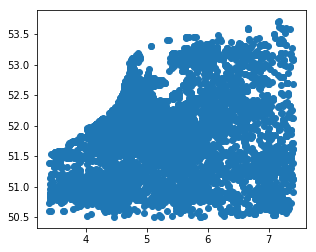

In [30]:
gdf.crs = {'init' :'epsg:4326'}
gdf.plot()